In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [3]:
df = pd.read_csv('data_llhajb.csv',sep=',' )

AUTO = tf.data.experimental.AUTOTUNE

In [4]:
df.head()

,path_image,lebel
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [5]:
a=df.copy()
a=pd.get_dummies(a['lebel'])
df1=pd.concat([df, a], axis=1)
df1.head()

,path_image,lebel,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,1,0


In [6]:
data=df1[df1['puceron noir']!=1]

In [7]:
data=data[data['scolytes']!=1]
data=data[data['coryneum']!=1]

In [8]:
data.drop(columns='lebel', inplace=True)

data.shape

(325, 10)

In [9]:
data.drop(columns=['puceron noir','scolytes','coryneum'],inplace=True)

In [10]:
data.head()

,path_image,acariens,chancre fusicocum,faux tigre,othyorinques,polystigma,rouille
0,new_data0.jpeg,0,0,0,0,0,1
1,new_data1.jpeg,0,0,0,0,0,1
2,new_data2.jpeg,0,0,0,0,0,1
3,new_data3.jpeg,0,0,0,0,0,1
4,new_data4.jpeg,0,0,0,0,0,1


In [11]:
data.columns

Index(['path_image', 'acariens', 'chancre fusicocum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille'],
      dtype='object')

<ipython-input-12-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()


<AxesSubplot:ylabel='None'>

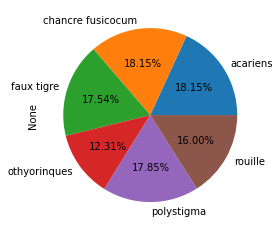

In [12]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [12]:
img_size={'height': 960,
         'width': 1280 }

In [13]:
data.shape

(325, 7)

In [14]:
path='paths/'
data_path=data.path_image.apply(lambda x: path +x).values

(1280, 958, 3)


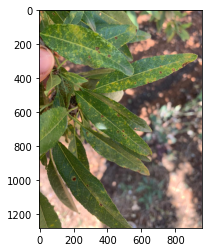

In [15]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [16]:
data_path

array(['paths/new_data0.jpeg', 'paths/new_data1.jpeg',
       'paths/new_data2.jpeg', 'paths/new_data3.jpeg',
       'paths/new_data4.jpeg', 'paths/new_data5.jpeg',
       'paths/new_data6.jpeg', 'paths/new_data7.jpeg',
       'paths/new_data8.jpeg', 'paths/new_data9.jpeg',
       'paths/new_data10.jpeg', 'paths/new_data11.jpeg',
       'paths/new_data12.jpeg', 'paths/new_data13.jpeg',
       'paths/new_data14.jpeg', 'paths/new_data15.jpeg',
       'paths/new_data16.jpeg', 'paths/new_data17.jpeg',
       'paths/new_data18.jpeg', 'paths/new_data19.jpeg',
       'paths/new_data20.jpeg', 'paths/new_data21.jpeg',
       'paths/new_data22.jpeg', 'paths/new_data23.jpeg',
       'paths/new_data24.jpeg', 'paths/new_data25.jpeg',
       'paths/new_data26.jpeg', 'paths/new_data27.jpeg',
       'paths/new_data28.jpeg', 'paths/new_data29.jpeg',
       'paths/new_data30.jpeg', 'paths/new_data31.jpeg',
       'paths/new_data32.jpeg', 'paths/new_data33.jpeg',
       'paths/new_data34.jpeg', 'paths/ne

In [17]:
data_labels = data.loc[:, ['acariens', 'chancre fusicocum', 'faux tigre','othyorinques', 'polystigma', 'rouille']].values

In [19]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [53]:
len(test_paths)

65

In [20]:
IMG_SIZE=300
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [41]:
BATCH_SIZE = 16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [42]:
LR_START = 0.0001
LR_MAX = 0.00005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [86]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('/modelll/model')
Dense_net.trainable=False

In [89]:
x = Dense_net.get_layer("global_average_pooling2d_3").output
x.trainable=False
x = tf.keras.layers.Dense(1024, activation='softmax')(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)
model = keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [90]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_33[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [91]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // BATCH_SIZE,
    epochs=40,
    validation_data=test_dataset
    )

Epoch 1/40
20/20 [==============================] - 8s 264ms/step - loss: 1.7911 - accuracy: 0.2109 - val_loss: 1.7896 - val_accuracy: 0.2154
Epoch 2/40
20/20 [==============================] - 4s 229ms/step - loss: 1.7879 - accuracy: 0.2457 - val_loss: 1.7865 - val_accuracy: 0.2769
Epoch 3/40
20/20 [==============================] - 5s 231ms/step - loss: 1.7806 - accuracy: 0.2866 - val_loss: 1.7829 - val_accuracy: 0.2615
Epoch 4/40
20/20 [==============================] - 5s 229ms/step - loss: 1.7809 - accuracy: 0.2375 - val_loss: 1.7744 - val_accuracy: 0.2769
Epoch 5/40
20/20 [==============================] - 5s 231ms/step - loss: 1.7644 - accuracy: 0.3849 - val_loss: 1.7654 - val_accuracy: 0.2462
Epoch 6/40
20/20 [==============================] - 5s 230ms/step - loss: 1.7571 - accuracy: 0.3015 - val_loss: 1.7548 - val_accuracy: 0.2615
Epoch 7/40
20/20 [==============================] - 4s 227ms/step - loss: 1.7326 - accuracy: 0.3991 - val_loss: 1.7399 - val_accuracy: 0.2769
Epoch 

In [92]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

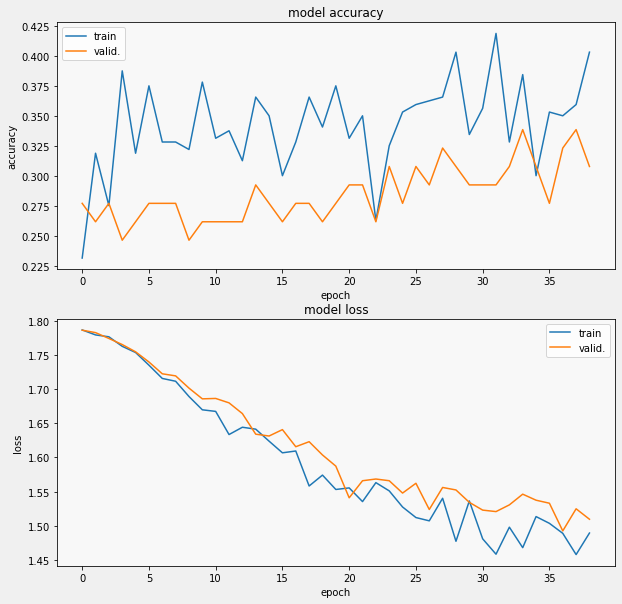

In [93]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [94]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=16)
print("new loss, new acc:", results)

Evaluate on test data
5/5 [==============================] - 2s 128ms/step - loss: 1.5177 - accuracy: 0.3231
new loss, new acc: [1.5176913738250732, 0.32307693362236023]


In [56]:
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

In [74]:
rounded_predictions = model.predict(test_dataset, batch_size=16, verbose=0)
rounded_predictions[1]

array([0.10257314, 0.49340144, 0.09358095, 0.08707107, 0.12027925,
       0.10309414], dtype=float32)

In [78]:
import numpy as np
rounded_labels=np.argmax(test_labels, axis=1)
rounded_labels[1]

1

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [31]:

for layer in model.layers:
    print("========="+layer.name)
    print(layer.trainable == True)

=========input_33
True
=========block1_conv1
True
=========block1_conv1_bn
True
=========block1_conv1_act
True
=========block1_conv2
True
=========block1_conv2_bn
True
=========block1_conv2_act
True
=========block2_sepconv1
True
=========block2_sepconv1_bn
True
=========block2_sepconv2_act
True
=========block2_sepconv2
True
=========block2_sepconv2_bn
True
=========conv2d_27
True
=========block2_pool
True
=========batch_normalization_12
True
=========add_36
True
=========block3_sepconv1_act
True
=========block3_sepconv1
True
=========block3_sepconv1_bn
True
=========block3_sepconv2_act
True
=========block3_sepconv2
True
=========block3_sepconv2_bn
True
=========conv2d_28
True
=========block3_pool
True
=========batch_normalization_13
True
=========add_37
True
=========block4_sepconv1_act
True
=========block4_sepconv1
True
=========block4_sepconv1_bn
True
=========block4_sepconv2_act
True
=========block4_sepconv2
True
=========block4_sepconv2_bn
True
=========conv2d_29
True
=========bloc